In [211]:
library(tidyverse)
library(magrittr)
library(fuzzyjoin)
library(ggpattern)


Attaching package: ‘ggpattern’


The following objects are masked from ‘package:ggplot2’:

    flip_data, flipped_names, gg_dep, has_flipped_aes, remove_missing,
    should_stop, waiver




In [29]:
grades <- read_csv("datasets/strixhaven_grades.csv")
cards <- read_csv("datasets/stx.csv")


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  `Card Name` = col_character(),
  `Mana Value` = col_character(),
  Rarity = col_character(),
  `Card Type` = col_character(),
  Color = col_character(),
  Nizzahon = col_character(),
  `LoL Grade` = col_character(),
  Deathsie = col_character(),
  `Lim Resources` = col_character()
)



── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  multiverse_id = col_double(),
  mtgo_id = col_double(),
  set = col_character(),
  collector_number = col_double(),
  lang = col_character(),
  rarity = col_character(),
  name = col_character(),
  mana_cost = col_character(),
  cmc = col_double(),
  type_line = col_charact

In [30]:
colnames(grades) <- c("name", "mana_value", "rarity", "card_type", "color", 
                      "nizzahon", "lords_of_limited", "deathsie", "lrcast")

In [63]:
grade_point <- function(grade) {
    mean(case_when(grepl("^A", grade) ~ 4,
                   grepl("^B", grade) ~ 3,
                   grepl("^C", grade) ~ 2,
                   grepl("^D", grade) ~ 1,
                   grepl("^F", grade) ~ 0,
                   TRUE ~ as.numeric(NA)) +
         case_when(grepl("\\+$", grade) ~ 1/3,
                   grepl("\\-$", grade) ~ -1/3,
                   TRUE ~ 0),
         na.rm = TRUE)
}

In [114]:
colors_from_cost <- function(mana_cost) {
  colors <- c()
  for (c in c("W", "U", "B", "R", "G")) {
    if (grepl(sprintf("\\{[^{^}]*%s.*[^{^}]*\\}", c), mana_cost)) {
      colors <- c(colors, c)
    }
  }

  paste0(colors, collapse = "")
}

In [164]:
graded.data <- grades %>%
  mutate(name = gsub("/", " // ", name)) %>%
  left_join(cards %>% select(c(name, mana_cost)), by = "name") %>%
  filter(rarity %in% c("Common", "Uncommon")) %>%
  select(-c(card_type, mana_value)) %>%
  reshape2::melt(id.vars = c("name", "color", "mana_cost", "rarity"), value.name = "grade") %>%
  rename(creator = variable) %>%
  mutate(grades = strsplit(grade, "/"),
         grade.points = map_dbl(grades, grade_point)) %>%
  mutate(colors = map_chr(mana_cost, colors_from_cost), color,
         colors = if_else(colors != "", colors, 
                          recode(color, 
                                 White = "W",
                                 Blue = "U",
                                 Black = "B",
                                 Red = "R",
                                 Green = "G",
                                 Colorless = "",
                                 Multicolor = ""))) %>%
  group_by(name, colors, rarity) %>%
  summarise(gpa = mean(grade.points, na.rm = TRUE))

`summarise()` has grouped output by 'name', 'colors'. You can override using the `.groups` argument.



In [188]:
wubrg.order <- c("W", "U", "B", "R", "G", "WB", "UR", "BG", "WR", "UG")
color.groups <- data.frame(colors = wubrg.order)

In [189]:
aggregate.res <- suppressWarnings(
  fuzzy_inner_join(color.groups, graded.data, 
                   by = "colors", match_fun = stringr::str_detect)
  ) %>%
  group_by(colors.x, rarity) %>%
  summarise(cards = n(),
            mean.grade = mean(gpa),
            gte.c = sum(if_else(gpa >= 2, 1, 0)),
            gte.b.minus = sum(if_else(gpa >= 2.66, 1, 0))) %>%
  mutate(colors.x = factor(colors.x, levels = wubrg.order)) %>%
  rename(colors = colors.x) %>%
  arrange(rarity, colors)

`summarise()` has grouped output by 'colors.x'. You can override using the `.groups` argument.



In [190]:
aggregate.res

aggregate.res %>%
  group_by(colors) %>%
  summarise(mean.grade = sum(mean.grade * cards) / sum(cards),
            cards = sum(cards),
            gte.c = sum(gte.c),
            gte.b.minus = sum(gte.b.minus)) %>%
  select(c(colors, cards, everything()))

colors,rarity,cards,mean.grade,gte.c,gte.b.minus
<fct>,<chr>,<int>,<dbl>,<dbl>,<dbl>
W,Common,12,1.756944,3,0
U,Common,12,1.746528,4,1
B,Common,12,1.965278,6,1
R,Common,12,1.850694,7,1
G,Common,12,1.915509,5,2
WB,Common,30,1.927778,13,1
UR,Common,30,1.854167,15,3
BG,Common,30,1.956481,15,3
WR,Common,30,1.820833,13,1


colors,cards,mean.grade,gte.c,gte.b.minus
<fct>,<int>,<dbl>,<dbl>,<dbl>
W,24,1.708912,7,2
U,25,1.822778,9,3
B,25,2.203889,16,8
R,25,1.920000,14,3
G,24,2.179398,14,8
WB,61,2.030510,31,12
UR,62,1.967518,33,11
BG,61,2.223816,40,20
WR,61,1.895719,30,7


In [196]:
options(repr.plot.width = 12,
        repr.plot.height = 8,
        repr.plot.res = 300)

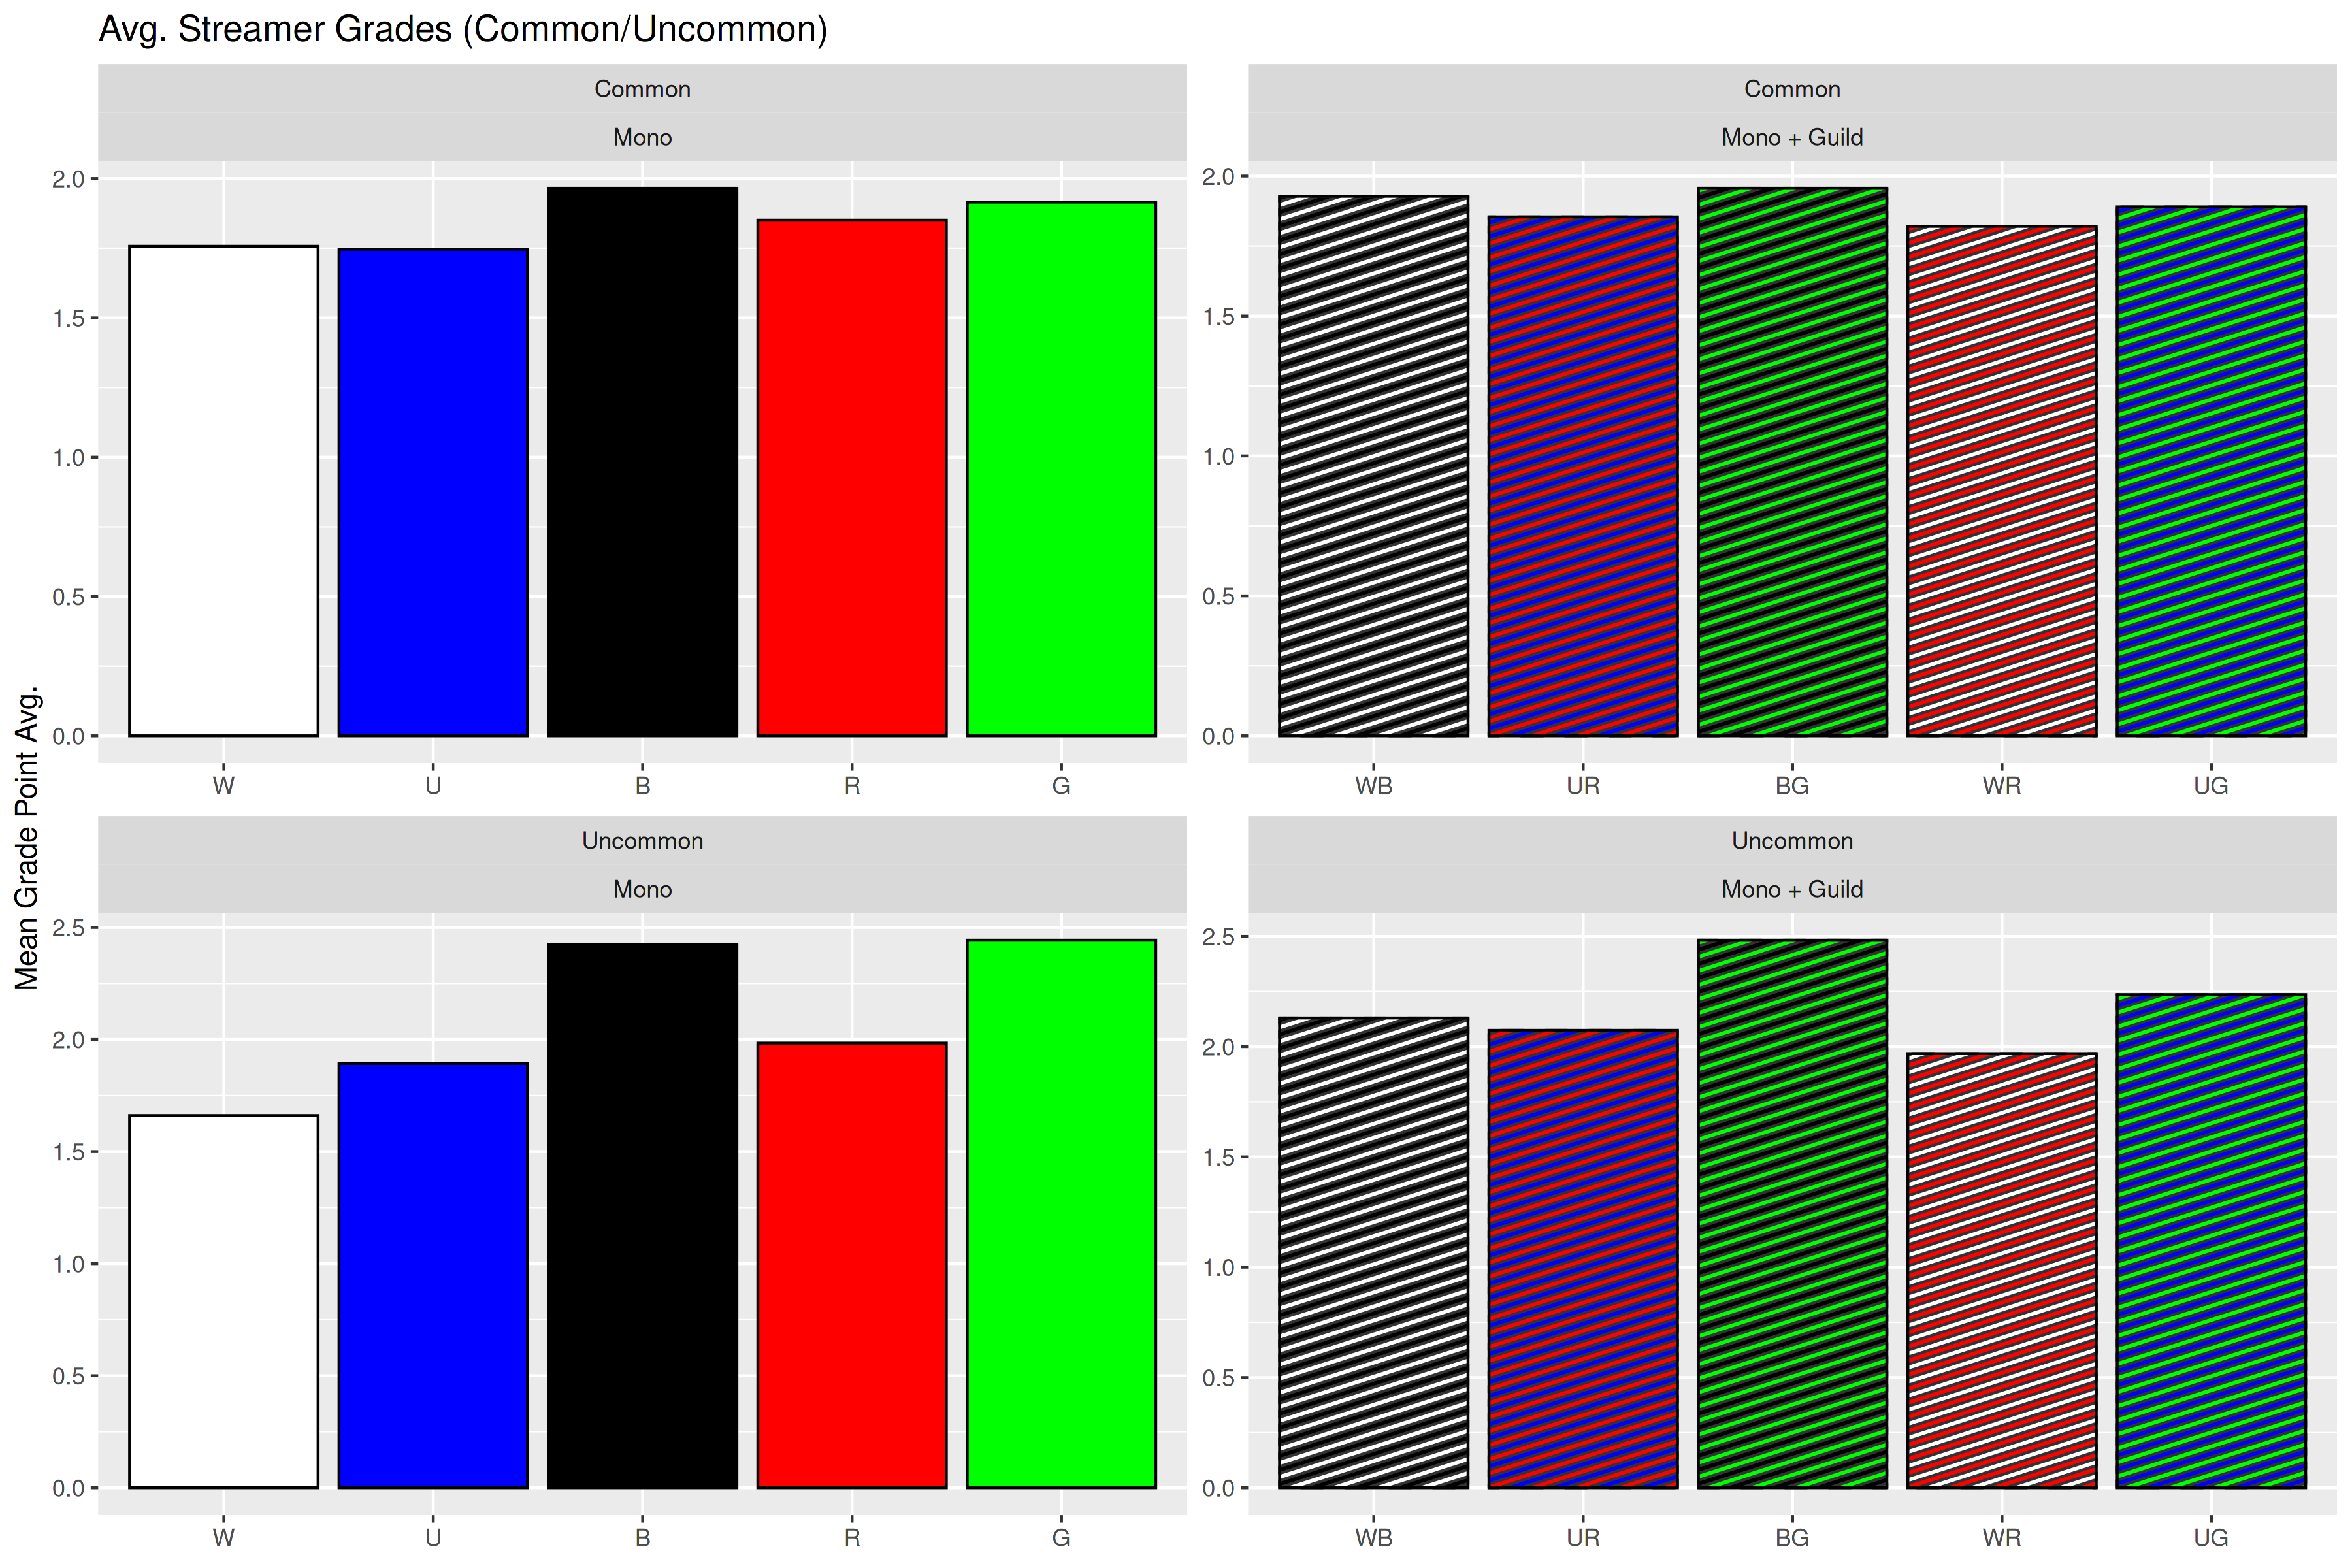

In [336]:
aggregate.res %>%
  mutate(color.count = nchar(as.character(colors)),
         color.count = if_else(color.count == 1, "Mono", "Mono + Guild")) %>%
  ggplot(aes(x = colors, y = mean.grade, fill = colors)) +
    geom_col_pattern(position = "dodge", pattern = "stripe", pattern_spacing = 0.02, color = "black",
                     aes(pattern_density = color.count, pattern_fill = colors)) +
    scale_fill_manual(
      values = c(
        W = "white",
        U = "blue",
        B = "black",
        R = "red",
        G = "green",
        WB = "white",
        UR = "blue",
        BG = "black",
        WR = "red",
        UG = "green"
      )
    ) +
    scale_pattern_fill_manual(
      values = c(
        W = "white",
        U = "blue",
        B = "black",
        R = "red",
        G = "green",
        WB = "black",
        UR = "red",
        BG = "green",
        WR = "white",
        UG = "blue"
      )
    ) +
    facet_wrap(~rarity + color.count, scales = "free") +
    ggtitle("Avg. Streamer Grades (Common/Uncommon)") +
    labs(y = "Mean Grade Point Avg.") +
    theme(axis.title.x = element_blank(),
          legend.position = "none")

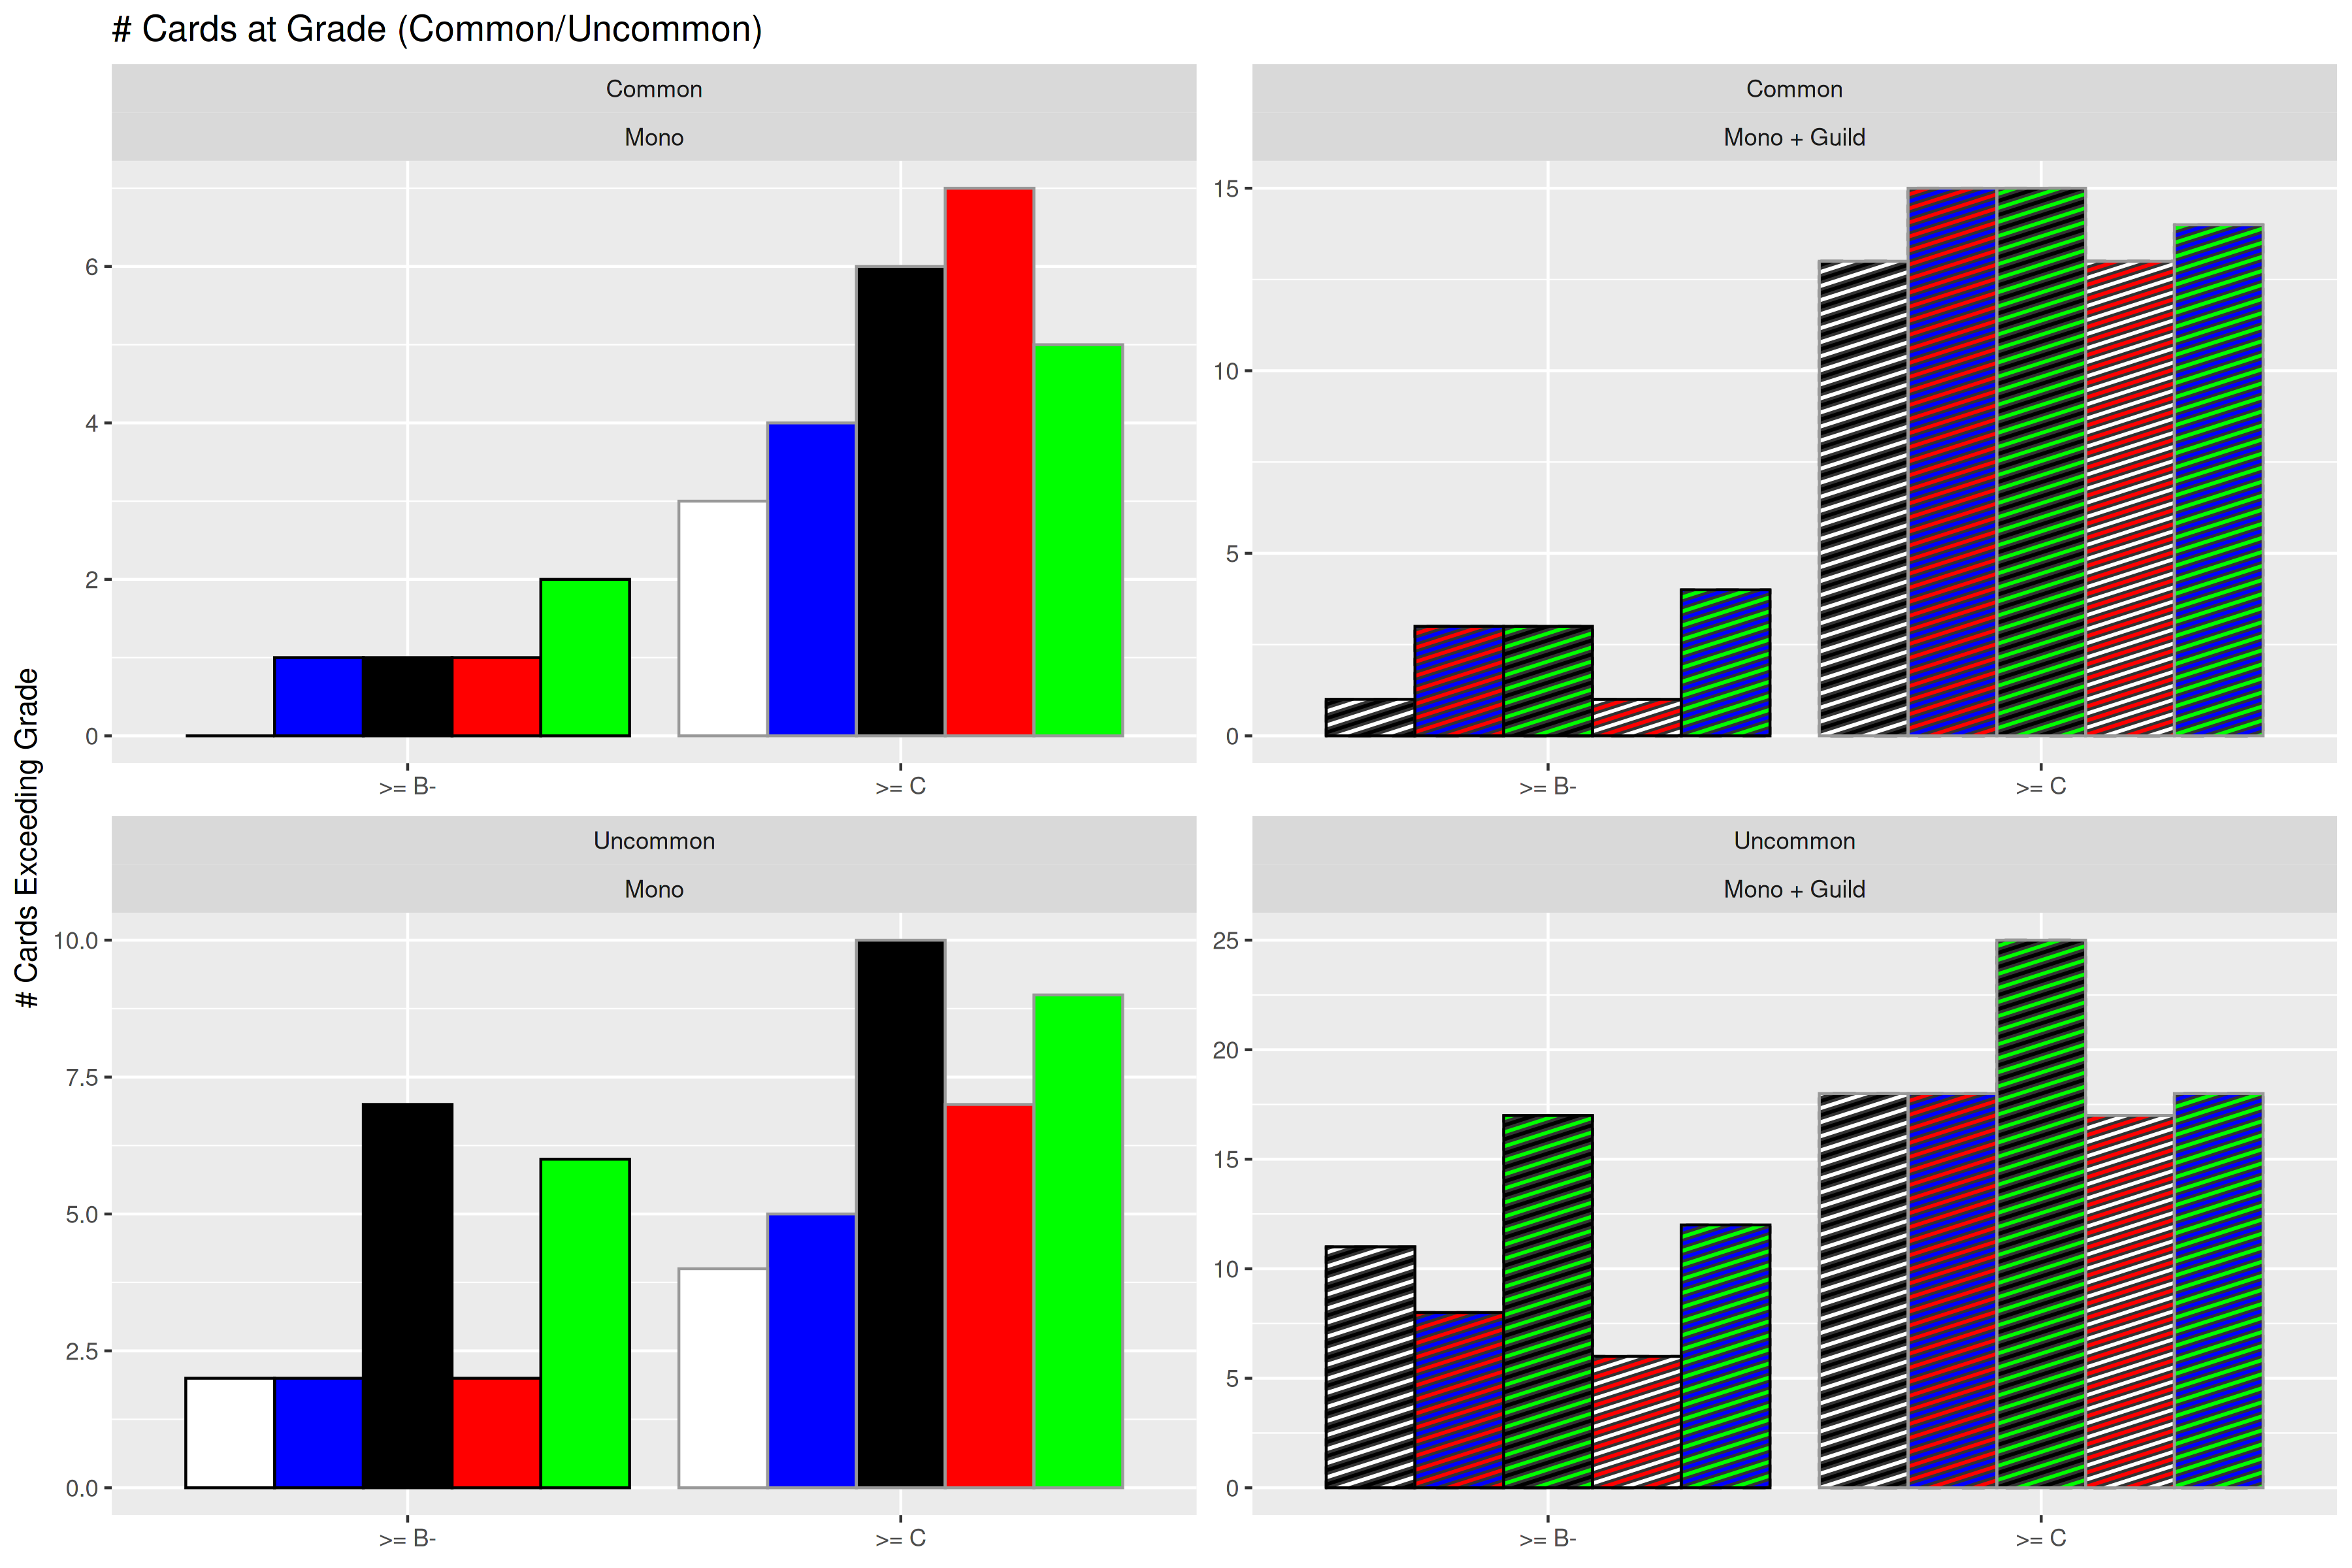

In [334]:
aggregate.res %>%
  mutate(color.count = nchar(as.character(colors)),
         color.count = if_else(color.count == 1, "Mono", "Mono + Guild")) %>%
  select(-c(mean.grade, cards)) %>%
  pivot_longer(cols = -c(colors, rarity, color.count)) %>%
  mutate(name = if_else(name == "gte.b.minus", ">= B-", ">= C")) %>%
  ggplot(aes(x = name, y = value, fill = colors)) +
    geom_col_pattern(position = "dodge", pattern = "stripe", pattern_spacing = 0.02,
                     aes(pattern_density = color.count, pattern_fill = colors, color = name)) +
    scale_fill_manual(
      values = c(
        W = "white",
        U = "blue",
        B = "black",
        R = "red",
        G = "green",
        WB = "white",
        UR = "blue",
        BG = "black",
        WR = "red",
        UG = "green"
      )
    ) +
    scale_pattern_fill_manual(
      values = c(
        W = "white",
        U = "blue",
        B = "black",
        R = "red",
        G = "green",
        WB = "black",
        UR = "red",
        BG = "green",
        WR = "white",
        UG = "blue"
      )
    ) +
    scale_color_manual(values = c(">= B-" = "black", ">= C" = "gray60")) +
    facet_wrap(~rarity + color.count, scales = "free") +
    ggtitle("# Cards at Grade (Common/Uncommon)") +
    labs(y = "# Cards Exceeding Grade", color = "Grade Floor", fill = "Color(s)") +
    theme(legend.position = "none",
          axis.title.x = element_blank())